In [1]:
# packages
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw as d
from rdkit.ML.Cluster import Butina

In [2]:
# 读取.parquet文件
data_de_train  = pd.read_parquet('data/de_train.parquet')
np.shape(data_de_train )

(614, 18216)

In [3]:
(614-15*2)/4  # 在B 与N细胞中各有15种药物的train，+4*（144+2）

146.0

In [5]:
data_de_train.columns

Index(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'A1BG',
       'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18216)

#### 基因的变化稀疏性检验（计算基因表达方差）

In [10]:
# gene_var = np.var(data_de_train.iloc[:,5:])

In [14]:
np.unique(data_de_train.cell_type)

array(['B cells', 'Myeloid cells', 'NK cells', 'T cells CD4+',
       'T cells CD8+', 'T regulatory cells'], dtype=object)

In [15]:
np.unique(test_data.sm_lincs_id)

array(['LSM-1011', 'LSM-1027', 'LSM-1071', 'LSM-1115', 'LSM-1158',
       'LSM-1181', 'LSM-1205', 'LSM-2334', 'LSM-4255', 'LSM-43181',
       'LSM-45496', 'LSM-45574', 'LSM-45916', 'LSM-47425', 'LSM-4944',
       'LSM-6237', 'LSM-6303'], dtype=object)

In [9]:
test_data = data_de_train[(data_de_train["cell_type"] == 'B cells') | (data_de_train["cell_type"] == 'Myeloid cells')]

In [16]:
# def write_in_file( cell_type):
#     data = data_de_train[(data_de_train["cell_type"] == cell_type)]
#     file_name = cell_type+"train.csv"
#     data.to_csv(file_name, index=False)
    

In [10]:
np.shape(test_data)

(34, 18216)

In [13]:
np.unique(test_data.sm_name)

array(['Alvocidib', 'Belinostat', 'CHIR-99021', 'Crizotinib',
       'Dabrafenib', 'Dactolisib', 'Foretinib', 'Idelalisib',
       'LDN 193189', 'Linagliptin', 'MLN 2238',
       'O-Demethylated Adapalene', 'Oprozomib (ONX 0912)', 'Palbociclib',
       'Penfluridol', 'Porcn Inhibitor III', 'R428'], dtype=object)

Belinostat and Dabrafenib are psitive exp

 'Dactolisib',  'MLN 2238', 'O-Demethylated Adapalene', 'Porcn Inhibitor III'

In [ ]:
ixazomib; IWP-L6; CD 437; NVP BEZ235

In [14]:
len(np.unique(test_data.sm_name))

17

In [18]:
(614 - 34)/4

145.0

In [12]:
gene_var.describe()

count    18211.000000
mean         5.452238
std          6.724921
min          0.347308
25%          1.350336
50%          3.198558
75%          7.058454
max        147.859276
dtype: float64

In [4]:
gene_names = data_de_train.columns[5:]

In [4]:
len(gene_names)

18211

In [5]:
# Assuming gene_names is an Index object
gene_names_df = pd.DataFrame({'gene_names': gene_names})
gene_names_df.to_csv('gene_names.csv', index=False)


In [7]:
len(np.unique(data_de_train.sm_name))

146

In [6]:
SMILES = np.unique(data_de_train["SMILES"])


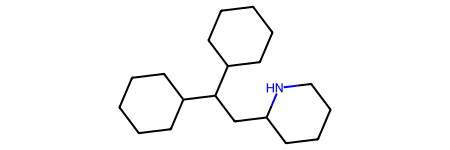

In [11]:
smiles = 'C1CCC(C(CC2CCCCN2)C2CCCCC2)CC1'

# 将SMILES字符串解析为分子对象
mol = AllChem.MolFromSmiles(smiles)
mol
# AllChem.GetMorganFingerprint(mol,2)

In [8]:
for i in SMILES :
    AllChem.MolFromSmiles(i)
    # print(ch.MolFromSmiles(i))

In [28]:
# mol_fingerprints = [(mol,ch.GetMorganFingerprint(mol,2)) for mol in SMILES]

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(str, int)
did not match C++ signature:
    GetMorganFingerprint(class RDKit::ROMol mol, unsigned int radius, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [12]:
# 从SMILES字符串创建分子对象
smiles_list = np.unique(data_de_train["SMILES"])
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
# 选择分子指纹类型，例如Morgan指纹
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in molecules]

# 初始化相似性矩阵为全零矩阵
similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))

# 计算相似性矩阵
for i in range(len(fingerprints)):
    for j in range(i + 1, len(fingerprints)):
        similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
        similarity_matrix[i, j] = 1 - similarity  # 将相似性转化为距离
        similarity_matrix[j, i] = 1 - similarity  # 设置对称位置的值，直接使用 NumPy
        
similarity_matrix = similarity_matrix.astype(float)

### K-means聚类

In [ ]:
from sklearn.cluster import KMeans

similarity_matrix = similarity_matrix.astype(float)

# 创建 K-Means 聚类模型，设置聚类数
n_clusters = 3  # 你可以根据需要设置聚类数
kmeans = KMeans(n_clusters=n_clusters)

# 对相似性矩阵进行聚类
kmeans.fit(similarity_matrix)

# 获取每个分子的聚类标签
cluster_labels = kmeans.labels_

# 打印聚类标签
print(cluster_labels)

### 层次聚类

In [13]:
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

C:\Users\THINK\AppData\Local\Temp/ipykernel_7424/2373751295.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(similarity_matrix, method='average')  # 这里使用平均链接


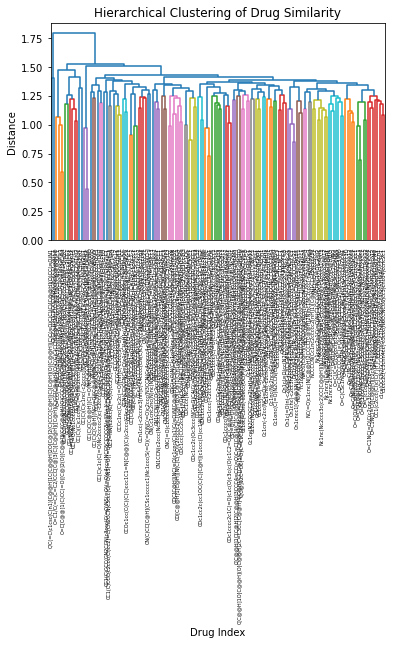

In [22]:
linkage_matrix = hierarchy.linkage(similarity_matrix, method='average')  # 这里使用平均链接

# 绘制层次聚类图
dendrogram = hierarchy.dendrogram(linkage_matrix)

# 显示图形
plt.xlabel('Drug Index')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering of Drug Similarity')

ax = plt.gca()  
ax.set_xticklabels(smiles_list, rotation=90)

plt.savefig("Hierarchical clustering.pdf")

plt.show()

In [24]:
linkage_matrix

array([[ 89.        ,  90.        ,   0.44270135,   2.        ],
       [120.        , 121.        ,   0.59223986,   2.        ],
       [ 62.        ,  66.        ,   0.69177446,   2.        ],
       [ 25.        ,  42.        ,   0.72712095,   2.        ],
       [ 85.        , 128.        ,   0.85200303,   2.        ],
       [125.        , 126.        ,   0.86720688,   2.        ],
       [  6.        , 102.        ,   0.91136341,   2.        ],
       [ 24.        , 149.        ,   0.96962673,   3.        ],
       [ 93.        , 146.        ,   0.97458511,   3.        ],
       [ 67.        , 148.        ,   0.98498058,   3.        ],
       [ 55.        , 104.        ,   0.9853925 ,   2.        ],
       [ 21.        , 133.        ,   0.9915431 ,   2.        ],
       [117.        , 147.        ,   0.99516247,   3.        ],
       [ 43.        , 123.        ,   0.99587398,   2.        ],
       [106.        , 150.        ,   1.00286663,   3.        ],
       [137.        , 144

In [25]:
# 假设我们希望有5个聚类
clusters = hierarchy.fcluster(linkage_matrix, 5, criterion='maxclust')
# np.savetxt("clusters.csv", clusters, delimiter=",")


In [33]:
for i in range(146):
        if clusters[i] ==1:
            print(i)

31
113


In [34]:
SMILES[31]

'CCN(CC)C(=S)SSC(=S)N(CC)CC'

In [35]:
SMILES[113]

'NC(O)=NO'

In [40]:
data_de_train.columns[1:5]

Index(['sm_name', 'sm_lincs_id', 'SMILES', 'control'], dtype='object')

In [49]:
drug_pairs = data_de_train.loc[:,["sm_name", "SMILES"]]

In [54]:
drug_pairs.shape

(614, 2)

In [55]:
for i in range(614):
        if drug_pairs.iloc[i,1]==SMILES[31]:
            print(31)
            print(drug_pairs.iloc[i,0])
            
        elif drug_pairs.iloc[i,1]==SMILES[113]:
            print(113)
            print(drug_pairs.iloc[i,0])

31
Disulfiram
31
Disulfiram
31
Disulfiram
31
Disulfiram
113
HYDROXYUREA
113
HYDROXYUREA
113
HYDROXYUREA
113
HYDROXYUREA
